In [1]:
%matplotlib notebook

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from cpyment import CModel

In [194]:
# Agent based model, using Gillespie's algorithm
def agentSIRT(tmax, beta=0.3, gamma=0.1, theta0=0.1, theta=0.1, N=1000, N_I=10):
    # Create a population
    pop = np.zeros((N, 3)).astype(int)
    # Infections untraceable
    pop[:,2] = -1
    # Assign infected
    Ii0 = np.random.choice(range(N), size=N_I, replace=False)
    pop[Ii0,0] = 1 # I
    
    t = [0]
    traj = [[N-N_I, N_I, 0, 0]]
    
    while t[-1] < tmax:
        Si = np.where(pop[:,0] == 0)[0]
        Ii = np.where(pop[:,0] == 1)[0]
        Ri = np.where(pop[:,0] == 2)[0]
        Ti = np.where(pop[:,1])[0]
        Iuti = np.where((pop[:,0] == 1)*(pop[:,1] == 0))[0]
        Itraci = np.where((pop[:,0] == 1)*(pop[:,1] == 0)*np.isin(pop[:,2], Ti))[0]
        
        S = len(Si)
        I = len(Ii)
        R = len(Ri)
        T = len(Ti)
        Iut = len(Iuti)
        Itrac = len(Itraci)
        
        # Probabilities of various events
        wInf = beta*S*(I-T)/N
        wRec = gamma*I
        wTrace0 = theta0*Iut
        wTrace = theta*Itrac
        
        W = wInf + wRec + wTrace0 + wTrace
        if np.isclose(W, 0):
            t.append(tmax)
            traj.append([S, I, R, T])
            break
        
        dt = -np.log(np.random.random())/W
        
        t.append(t[-1]+dt)
        
        probs = np.array([wInf, wRec, wTrace0, wTrace])/W
        
        # WHICH event?
        etype = np.random.choice(range(4), p=probs)
        
        if etype == 0:
            # Infection
            si = np.random.choice(Si)
            ii = np.random.choice(Iuti)
            pop[si,0] = 1
            pop[si,2] = ii
            S -= 1
            I += 1
        elif etype == 1:
            # Recovery
            ii = np.random.choice(Ii)
            pop[ii,0] = 2
            T -= pop[ii,1]
            I -= 1
            R += 1
            pop[ii,1] = 0
        elif etype == 2:
            # Traced (randomly)
            ii = np.random.choice(Iuti)
            pop[ii,1] = 1
            T += 1
        elif etype == 3:
            # Traced (contact)
            ii = np.random.choice(Itraci)
            pop[ii,1] = 1
            T += 1
        
        traj.append([S, I, R, T])
    return t, traj

In [236]:
tmax = 100
N = 1000
N_I = 20
beta = 0.3
gamma = 0.1
theta0 = 0.05
theta = 100.0

n = 10
sttraj = []
for ni in range(n):
    print(ni)
    t, traj = agentSIRT(tmax, beta=beta, gamma=gamma, theta0=theta0, theta=theta, N=N, N_I=N_I)
    sttraj.append((t, traj))

0
1
2
3
4
5
6
7
8
9


In [237]:
taxis = np.linspace(0, tmax, 1000)

cm = CModel('SIRT')

cm.set_coupling_rate('S*I', beta/N)
cm.set_coupling_rate('I:I=>R', gamma)
cm.set_coupling_rate('I:I=>T', theta0)
cm.set_coupling_rate('I*T:I=>T', theta/N)
cm.set_coupling_rate('T:T=>R', gamma)

y0 = np.zeros(4).astype(float)
y0[0] = N-N_I
y0[1] = N_I

odetraj = cm.integrate(taxis, y0)

<IPython.core.display.Javascript object>


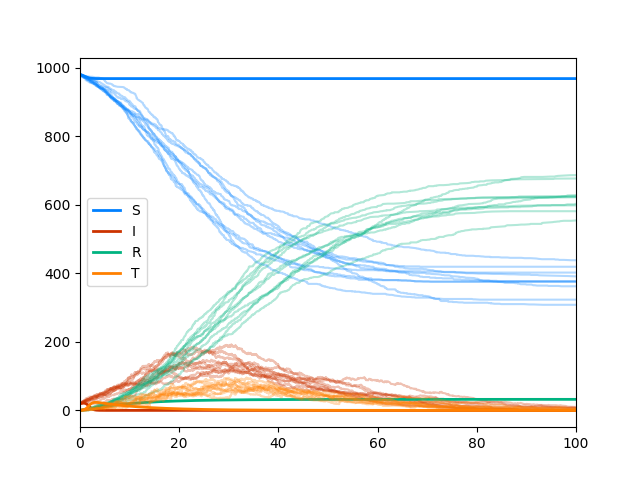

In [238]:
fig, ax = plt.subplots()

# Color code
ctable = {
    'S': (0.0, 0.5, 1.0),
    'I': (0.8, 0.2, 0.0),
    'R': (0.0, 0.7, 0.5),
    'T': (1.0, 0.5, 0.0),
 }

ax.set_xlim(0, tmax)

for i, l in enumerate('SIRT'):
    for st in sttraj:
        traj = np.array(st[1])
        ax.plot(st[0], traj[:,i], c=list(ctable[l]) + [0.3])
    ax.plot(taxis, odetraj['y'][:,i], label=l, c=ctable[l], lw=2)

ax.legend()